<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw8/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Women's Dress Review

* Tutorial: https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c

* Github: https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial

# New Section

**Download Dataset**

In [50]:
!pip install beautifulsoup4
!pip install vaderSentiment

     |████████████████████████████████| 133kB 4.5MB/s 


In [2]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup  

url = "https://www.politifact.com/factchecks/list/?page={pgno}&speaker={speaker}"

records = []  

for i in range(1,5):
  fUrl = url.format(pgno=str(i), speaker="donald-trump")
  r = requests.get(fUrl)
  soup = BeautifulSoup(r.text, 'html.parser')  
  results = soup.find_all('div', attrs={'class':'m-statement__body'})
  for result in results:
    date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")  
    reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy ","")
    statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
    article_url =  result.find('a')['href']
    verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
    records.append(( date,reporter, statement, verdict, article_url))
  
df = pd.DataFrame(records, columns=['Date','Reporter', 'Statement', 'Verdict', 'Url'])  
df.head()

,Date,Reporter,Statement,Verdict,Url
0,"March 30, 2021",Jon Greenberg,Says Deborah Birx “traveled a great distance t...,half-true,/factchecks/2021/mar/30/donald-trump/donald-tr...
1,"March 24, 2021",Amy Sherman,"""We proudly handed the Biden administration th...",barely-true,/factchecks/2021/mar/24/donald-trump/what-trum...
2,"March 2, 2021",Tom Kertscher,"Says he requested “10,000 National Guardsmen” ...",false,/factchecks/2021/mar/02/donald-trump/no-proof-...
3,"March 2, 2021",Amy Sherman,HR 1 “automatically registers every welfare re...,barely-true,/factchecks/2021/mar/02/donald-trump/trump-mis...
4,"March 1, 2021",Miriam Valverde,Says Joe Biden “has effectively ordered a shut...,false,/factchecks/2021/mar/01/donald-trump/cpac-retu...


In [3]:
#Get all issues

url = "https://www.politifact.com/issues/"
issues = []
r = requests.get(url)
soup = BeautifulSoup(r.text,'html.parser')
results = soup.find_all('div', attrs={'class':'c-chyron__value'})
for result in results:
  name = result.find('a').text
  issue = result.find('a')['href'].replace("/","")
  issues.append((name, issue))

In [4]:
url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

records = []  

for i in range(1,2):
  for issue, issue_url in issues[:5]:
    fUrl = url.format(pgno=str(i), category=issue_url)
    r = requests.get(fUrl)
    soup = BeautifulSoup(r.text, 'html.parser')  
    results = soup.find_all('article', attrs={'class':'m-statement'})
    for result in results:
      date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
      reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
      author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
      statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
      statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
      article_url =  result.find('a')['href']
      verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
      records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  
df_sample = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_sample.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
1,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
2,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
3,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/
4,"October 13, 2020",Abortion,Chris Nichols,Facebook posts,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false,/personalities/facebook-posts/


In [7]:
df_sample.isnull().sum()

Date           0
Issue          0
Reporter       0
Author         0
Statement      0
Description    0
Verdict        0
Url            0
dtype: int64

**Import All Required Packages**

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Read data from csv**

**Drop unnecessary columns**

In [51]:
df = df_sample.drop(['Date', 'Issue', 'Reporter', 'Author', 'Url'], axis=1)
#df.dropna(inplace=True)

In [52]:
df.head()

,Statement,Description,Verdict
0,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true
1,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false
2,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false
3,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false
4,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false


**Plot the Rating visualization graph**

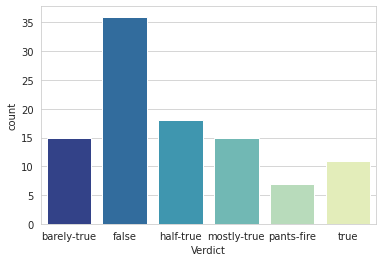

In [25]:
sns.set_style('whitegrid')
sns.countplot(x='Verdict',data=df, palette='YlGnBu_r')

**Calculation of Polarity**

In [56]:
df['Polarity_Rating'] = df['Verdict'].apply(lambda x: 'Positive' if x in ['true', 'mostly-true'] else('Neutral' if x in ['half-true']  else 'Negative'))


**Plot the Polarity Rating count**

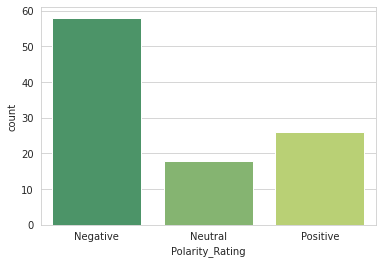

In [27]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette='summer')

**Data Preprocessing**

In [36]:
df_Positive = df[df['Polarity_Rating'] == 'Positive']
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

**Sample negative and neutral polarity dataset and create final dataframe**

In [ ]:
#df = pd.concat([df_Positive, df_Neutral, df_Negative], axis=0)

**Text Preprocessing**

In [37]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

**Apply the method "get_text_processing" into column review text**

In [54]:
df['NewsDesciption'] = df['Description'].apply(get_text_processing)
df['NewsStatement'] = df['Statement'].apply(get_text_processing)
df.head()

,Statement,Description,Verdict,NewsDesciption,NewsStatement
0,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,stated March 29 2021 Facebook post,“Joe Biden puts prolife groups domestic extrem...
1,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,stated January 24 2021 tweet,“Innocent lives saved” ending taxpayer funding...
2,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,stated November 15 2020 Facebook post,“aborted male fetus” OxfordAstraZeneca “Covid ...
3,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,stated October 8 2020 ad,Says Doug Jones voted spend tax dollars latete...
4,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false,stated August 14 2020 headline,“Kamala Harris Tried Put ProLifers Jail Expose...


In [58]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return _sentiment

**Visualize Text Review with Polarity Rating**

In [57]:
df = df[['NewsStatement', 'Polarity_Rating']]
df.head()

,NewsStatement,Polarity_Rating
0,“Joe Biden puts prolife groups domestic extrem...,Negative
1,“Innocent lives saved” ending taxpayer funding...,Negative
2,“aborted male fetus” OxfordAstraZeneca “Covid ...,Negative
3,Says Doug Jones voted spend tax dollars latete...,Negative
4,“Kamala Harris Tried Put ProLifers Jail Expose...,Negative


**Apply One hot encoding on negative, neutral, and positive**

In [40]:
one_hot = pd.get_dummies(df["Polarity_Rating"])
df.drop(['Polarity_Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,NewsStatement,Negative,Neutral,Positive
0,“Joe Biden puts prolife groups domestic extrem...,1,0,0
1,“Innocent lives saved” ending taxpayer funding...,1,0,0
2,“aborted male fetus” OxfordAstraZeneca “Covid ...,1,0,0
3,Says Doug Jones voted spend tax dollars latete...,1,0,0
4,“Kamala Harris Tried Put ProLifers Jail Expose...,1,0,0


**Apply Train Test Split**

In [42]:
X = df['NewsStatement'].values
y = df.drop('NewsStatement', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

**Apply vectorization**

In [43]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

**Apply frequency, inverse document frequency:**

In [44]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

**Add different layers**

In [45]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

**Fit the Model**

In [46]:
model.fit(x=X_train, y=y_train, batch_size=5, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
15/15 [==============================] - 16s 887ms/step - loss: 1.1109 - accuracy: 0.3956 - val_loss: 0.8932 - val_accuracy: 0.6452
Epoch 2/100
15/15 [==============================] - 12s 831ms/step - loss: 0.8278 - accuracy: 0.5741 - val_loss: 0.6877 - val_accuracy: 0.7419
Epoch 3/100
15/15 [==============================] - 13s 846ms/step - loss: 0.3613 - accuracy: 0.7643 - val_loss: 0.6685 - val_accuracy: 0.7419
Epoch 4/100
15/15 [==============================] - 13s 842ms/step - loss: 0.0719 - accuracy: 0.9973 - val_loss: 0.7484 - val_accuracy: 0.7097
Epoch 5/100
15/15 [==============================] - 13s 834ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8350 - val_accuracy: 0.7419
Epoch 00005: early stopping


**Evaluation of Model**

In [47]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

1/1 [==============================] - 0s 137ms/step - loss: 0.8350 - accuracy: 0.7419
Test accuracy: 0.7419354915618896


**Prediction**

In [48]:
preds = model.predict(X_test)
preds

array([[4.51125950e-01, 6.67261854e-02, 4.82147843e-01],
       [9.77670550e-01, 1.95897035e-02, 2.73965765e-03],
       [9.99850750e-01, 1.47714736e-05, 1.34484304e-04],
       [1.18683400e-02, 8.83494616e-01, 1.04637071e-01],
       [1.11042827e-01, 1.31438049e-02, 8.75813365e-01],
       [9.99854565e-01, 1.15094284e-04, 3.02258177e-05],
       [7.61677563e-01, 6.63400814e-02, 1.71982363e-01],
       [2.00719401e-01, 4.34463620e-01, 3.64816993e-01],
       [3.23543139e-02, 4.17656116e-02, 9.25880134e-01],
       [9.85436261e-01, 5.93213364e-03, 8.63161590e-03],
       [9.99717295e-01, 5.24659008e-05, 2.30263118e-04],
       [9.99253213e-01, 9.41578764e-05, 6.52625400e-04],
       [9.98602688e-01, 8.07996141e-04, 5.89341624e-04],
       [9.71215308e-01, 1.46457576e-03, 2.73200758e-02],
       [1.75258026e-01, 6.14383698e-01, 2.10358322e-01],
       [9.99951005e-01, 1.35098589e-05, 3.55196462e-05],
       [9.56220210e-01, 4.25877087e-02, 1.19209290e-03],
       [7.11848334e-05, 8.98990